In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from nms import nms
from config_voting import *
%matplotlib inline

file_path = '/export/home/qliu24/qing_voting_data/intermediate/feat_pickle_VGG/'


oo = 'car'
fname = file_path + 'res_info_' + oo + '_train_carVC.pickle'
print('loading object {0}'.format(oo))
with open(fname, 'rb') as fh:
    layer_feature_dist, _, view_point = pickle.load(fh)
    
asp_ratio = [layer_feature_dist[ii].shape[1]/layer_feature_dist[ii].shape[0] for ii in range(len(layer_feature_dist))]
        
N = len(layer_feature_dist)
print('total number of instances {0}'.format(N))

# load original pool4 features
file_cache_feat = '/export/home/qliu24/qing_voting_data/intermediate/feat_VGG/car_mergelist_rand_train_carVC.pickle'
with open(file_cache_feat, 'rb') as fh:
    feat_set, layer_feature_dist = pickle.load(fh)
    

magic_thh = 0.85

layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (layer_feature_dist[nn]<magic_thh).astype(int)
    
view_point = np.array(view_point)
idx_s = np.where(np.logical_and(view_point>=67.5,view_point<=112.5))[0]

max_2 = max([layer_feature_b[nn].shape[2] for nn in idx_s])

max_1 = max([layer_feature_b[nn].shape[1] for nn in idx_s])

max_0 = max([layer_feature_b[nn].shape[0] for nn in idx_s])
print(max_0, max_1, max_2)
print(len(idx_s))

loading object car
total number of instances 1000
14 54 158
118


In [11]:
bg_feat_set = []
for nn in idx_s:
    row_ls, col_ls = np.where(np.sum(layer_feature_b[nn], axis=2)==0)
    if len(row_ls)==0:
        continue
        
    for pos in zip(row_ls, col_ls):
        bg_feat_set.append(feat_set[nn][pos[0],pos[1]])
        
print(len(bg_feat_set))

bg_feat_set = np.array(bg_feat_set)
bg_feat_set = bg_feat_set/np.sqrt(np.sum(bg_feat_set**2, axis=1).reshape(-1,1))

13992


In [12]:
layer_fire_nms = [np.zeros_like(layer_feature_b[nn]) for nn in idx_s]
for nni,nn in enumerate(idx_s):
    for vc_i in range(max_2):
        ri, ci = np.where(layer_feature_b[nn][:,:,vc_i]==1)
        if ri.size==0:
            continue
        
        r_list = Astride * ri + Arf/2 - Apad
        c_list = Astride * ci + Arf/2 - Apad
        bb_loc = np.column_stack([c_list-Arf/2, r_list-Arf/2, c_list+Arf/2, r_list+Arf/2])
        det = layer_feature_dist[nn][ri,ci,vc_i]
        
        bb_loc_ = np.column_stack([bb_loc, -det])
        nms_list = nms(bb_loc_, 0.05)
        layer_fire_nms[nni][ri[nms_list], ci[nms_list], vc_i] = 1
        
print(layer_fire_nms[0].shape)

(14, 40, 158)


In [9]:
for pp1,pp2 in zip([1,2,3],[3,4,5]):
    print(pp1,pp2)

1 3
2 4
3 5


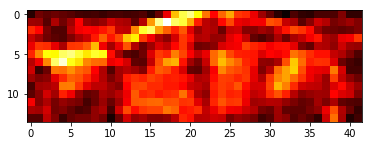

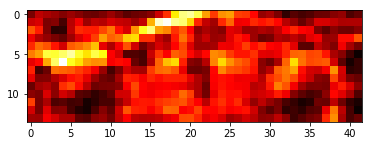

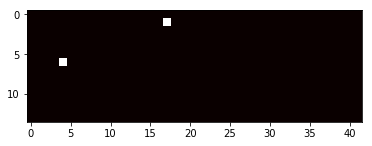

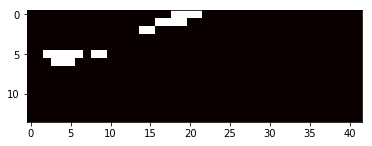

In [13]:
# bg_feat = np.mean(bg_feat_set,axis=0)
# bg_feat = np.random.random(512)
# bg_feat = bg_feat/np.sqrt(np.sum(bg_feat**2))

vc_i=143
nn=idx_s[22]
rnum, colnum = layer_feature_dist[nn].shape[0:2]
rst_diff = np.zeros((rnum, colnum))
for rr in range(rnum):
    for cc in range(colnum):
        ff = feat_set[nn][rr,cc]
        ff = ff/np.sqrt(np.sum(ff**2))
        
        diff_tmp = []
        
        for bgi in np.random.choice(len(bg_feat_set),size=(100,),replace=False):
            bg_ff = bg_feat_set[bgi]
            diff_tmp.append(np.sum((ff-bg_ff)**2))
        
        rst_diff[rr,cc] = np.mean(diff_tmp) - layer_feature_dist[nn][rr,cc,vc_i]**2
        
        # rst_diff[rr,cc] = np.sum((ff-bg_feat)**2) - layer_feature_dist[nn][rr,cc,vc_i]**2
            
plt.imshow(rst_diff, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(-layer_feature_dist[nn][:,:,vc_i]**2, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(layer_fire_nms[22][:,:,vc_i], cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(layer_feature_b[nn][:,:,vc_i], cmap='hot', interpolation='nearest')
plt.show()

In [14]:
heat_map_nms = np.zeros((max_0,max_1,max_2))
for ni in range(len(idx_s)):
    ri,ci,chi = layer_fire_nms[ni].shape
    assert(chi==max_2)
    diff_r_1 = int((max_0-ri)/2)
    diff_r_2 = max_0-ri-diff_r_1
    
    diff_c_1 = int((max_1-ci)/2)
    diff_c_2 = max_1-ci-diff_c_1
    
    heat_map_nms += np.pad(layer_fire_nms[ni], ((diff_r_1, diff_r_2),(diff_c_1, diff_c_2),(0,0)), 'constant', constant_values=0)

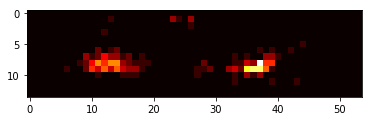

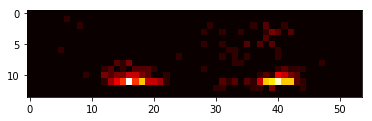

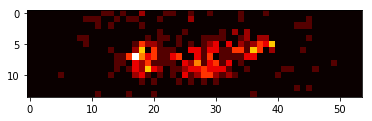

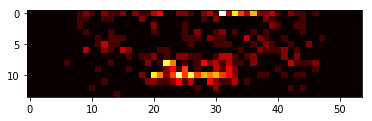

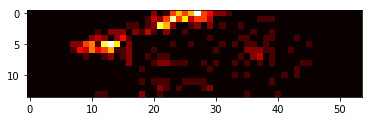

In [15]:
for vc_i in [1,15,46,65,143]:
    plt.imshow(heat_map_nms[:,:,vc_i]/len(idx_s), cmap='hot', interpolation='nearest')
    plt.show()

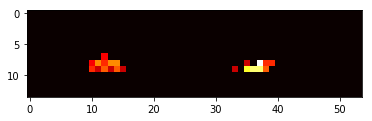

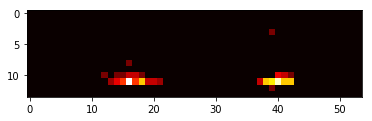

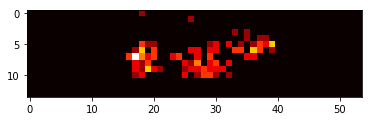

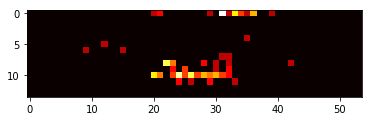

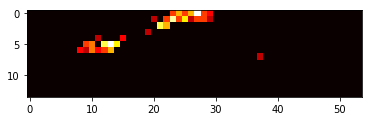

In [16]:
from copy import *
heat_map_nms_processed = np.zeros_like(heat_map_nms)
for vc_i in range(heat_map_nms.shape[2]):
    freq = heat_map_nms[:,:,vc_i]/len(idx_s)
    thrh = np.mean(freq[freq!=0])
    # print(thrh)
    freq[freq <= thrh]=0
    heat_map_nms_processed[:,:,vc_i] = deepcopy(freq)
    
for vc_i in [1,15,46,65,143]:
    plt.imshow(heat_map_nms_processed[:,:,vc_i], cmap='hot', interpolation='nearest')
    plt.show()

In [21]:
vc_i = 143
patch_dist_set = [[[],[],[]], [[],[],[]], [[],[],[]]]
for ni in range(len(idx_s)):
    ri,ci,chi = layer_fire_nms[ni].shape
    assert(chi==max_2)
    diff_r_1 = int((max_0-ri)/2)
    diff_r_2 = max_0-ri-diff_r_1
    
    diff_c_1 = int((max_1-ci)/2)
    diff_c_2 = max_1-ci-diff_c_1
    
    li_fire_nms_padded = np.pad(layer_fire_nms[ni][:,:,vc_i], ((diff_r_1, diff_r_2),(diff_c_1, diff_c_2)), 'constant', constant_values=0)
    li_dist = np.pad(layer_feature_dist[idx_s[ni]][:,:,vc_i], ((diff_r_1, diff_r_2),(diff_c_1, diff_c_2)), 'edge')
    rnms, cnms = np.where(li_fire_nms_padded==1)
    for pp in zip(rnms, cnms):
        if heat_map_nms_processed[pp[0],pp[1],vc_i]>0:
            for ri,rr in enumerate(range(pp[0]-1, pp[0]+2)):
                if rr < 0 or rr >= li_dist.shape[0]:
                    continue
                    
                for ci,cc in enumerate(range(pp[1]-1, pp[1]+2)):
                    if cc < 0 or cc >= li_dist.shape[1]:
                        continue
                        
                    patch_dist_set[ri][ci].append(li_dist[rr,cc]**2)
                    
for ri in range(3):
    for ci in range(3):
        print(np.mean(patch_dist_set[ri][ci]), np.std(patch_dist_set[ri][ci]))
        print(np.median(patch_dist_set[ri][ci]))
        hist, bin_edges = np.histogram(patch_dist_set[ri][ci])
        print(hist)
        print(bin_edges)
    

0.973788354494 0.173006181549
0.994575151229
[ 3  9 11  8 20 18 18 19 17 21]
[ 0.56287003  0.63178551  0.700701    0.76961648  0.83853197  0.90744745
  0.97636294  1.04527842  1.11419391  1.1831094   1.25202488]
0.858001560304 0.155561216651
0.851806850057
[ 7 12 21 23 24 17 19  9  5  7]
[ 0.54218968  0.61102787  0.67986606  0.74870424  0.81754243  0.88638061
  0.9552188   1.02405699  1.09289517  1.16173336  1.23057154]
0.811962286832 0.155524185851
0.797778569825
[ 9 17 27 26 21 16 11  8  5  4]
[ 0.5286076   0.59827362  0.66793964  0.73760566  0.80727168  0.87693771
  0.94660373  1.01626975  1.08593577  1.15560179  1.22526781]
0.672295046321 0.113949282401
0.662732369359
[ 5 11 27 42 33 30 15 14  5  6]
[ 0.41553141  0.47207607  0.52862073  0.58516539  0.64171004  0.6982547
  0.75479936  0.81134401  0.86788867  0.92443333  0.98097799]
0.574484804485 0.0804780624804
0.57144124601
[ 2  5 10 20 27 35 26 25 16 22]
[ 0.35867487  0.39494819  0.4312215   0.46749482  0.50376813  0.54004144
  0

In [30]:
vc_i = 143
patch_dist_set = [[[],[],[]], [[],[],[]], [[],[],[]]]
for ni in range(len(idx_s)):
    ri,ci,chi = layer_fire_nms[ni].shape
    assert(chi==max_2)
    diff_r_1 = int((max_0-ri)/2)
    diff_r_2 = max_0-ri-diff_r_1
    
    diff_c_1 = int((max_1-ci)/2)
    diff_c_2 = max_1-ci-diff_c_1
    
    li_fire_nms_padded = np.pad(layer_fire_nms[ni][:,:,vc_i], ((diff_r_1, diff_r_2),(diff_c_1, diff_c_2)), 'constant', constant_values=0)
    li_feat = np.pad(feat_set[idx_s[ni]], ((diff_r_1, diff_r_2),(diff_c_1, diff_c_2),(0,0)), 'edge')
    
    rnms, cnms = np.where(li_fire_nms_padded==1)
    for pp in zip(rnms, cnms):
        if heat_map_nms_processed[pp[0],pp[1],vc_i]>0:
            for ri,rr in enumerate(range(pp[0]-1, pp[0]+2)):
                if rr < 0 or rr >= li_dist.shape[0]:
                    continue
                    
                for ci,cc in enumerate(range(pp[1]-1, pp[1]+2)):
                    if cc < 0 or cc >= li_dist.shape[1]:
                        continue
                        
                    ff = li_feat[rr,cc]
                    ff = ff/np.sqrt(np.sum(ff**2))
                    diff_tmp = []
                    for bgi in np.random.choice(len(bg_feat_set),size=(100,),replace=False):
                        bg_ff = bg_feat_set[bgi]
                        diff_tmp.append(np.sum((ff-bg_ff)**2))
                        
                    patch_dist_set[ri][ci].append(np.mean(diff_tmp))
                    
for ri in range(3):
    for ci in range(3):
        print(np.mean(patch_dist_set[ri][ci]), np.std(patch_dist_set[ri][ci]))

1.68741 0.0545851
1.69864 0.054342
1.70364 0.0512553
1.71358 0.0443279
1.71993 0.0383625
1.71173 0.0423585
1.71385 0.038747
1.71378 0.0385872
1.71163 0.0441137
